In [1]:
%matplotlib widget
import os

import numpy as np
import scipy as sp
import open3d as o3d
import skimage
import sklearn
import matplotlib.pyplot as plt

import dicom

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from needle_reconstruction_ct import (
    ROI3D,
    CTNeedleReconstruction,
    CTNeedleReconstructionOptions,
)
from stereo_needle_proc import (
    arclength,
    axisEqual3D,
)
from util import BSplineND

In [3]:
# test processing
def reconstruct_needle(ct_nr, **kwargs):
    retval = dict()
    thresh_mask = ct_nr.dicom_image3d.image >= ct_nr.options.threshold
    roi_mask    = ct_nr.options.roi.get_mask(thresh_mask.shape, invert=False)
    bo_mask     = np.ones_like(roi_mask)
    for bor in ct_nr.options.blackout_regions:
        break
        bo_mask  &= bor.get_mask(
            thresh_mask.shape, 
            invert=True,
        )

    # for

    seg_mask = thresh_mask & roi_mask & bo_mask

    # segment needle
    seg_needle_mask = seg_mask & ct_nr.options.roi_needle.get_mask(seg_mask.shape, invert=False)
    for bor in ct_nr.options.blackout_regions_needle:
        seg_needle_mask &= bor.get_mask(
            seg_needle_mask.shape,
            invert=True
        )

    # for

    retval['needle_mask'] = seg_needle_mask

    lbl_needle_mask, num_classes = skimage.measure.label(
        seg_needle_mask,
        connectivity=1,
        return_num=True,
    )
    lbl_max = np.argmax(
        [
            np.sum(lbl_needle_mask == lbl)
            for lbl in range(1, num_classes)
        ]
    ) + 1
    seg_needle_mask = lbl_needle_mask == lbl_max
    retval["label_needle_mask"] = lbl_needle_mask

    seg_needle_skel_mask = skimage.morphology.skeletonize_3d(seg_needle_mask)
        
    # segment fiducials
    seg_fiducials_mask = seg_mask & ct_nr.options.roi_fiducials.get_mask(seg_mask.shape, invert=False)
    seg_fiducials_mask &= np.logical_not(seg_needle_mask)
    for bor in ct_nr.options.blackout_regions_fiducials:
        seg_fiducials_mask &= bor.get_mask(
            seg_fiducials_mask.shape,
            invert=True
        )

    # for
    

    retval['fiducials_mask'] = seg_fiducials_mask

    # get points out of fiducials
    pts_fiducials = np.argwhere(seg_fiducials_mask).astype(np.float64)
    # pts_fiducials *= ct_nr.dicom_image3d.image_axis_scaling.reshape(1, -1)

    retval["fiducial_pts_img"] = pts_fiducials

    # pts_fiducials = ct_nr.determine_fiducial_locations(seg_fiducials_mask)
    # retval["fiducial_pts"] = pts_fiducials
    
    # get points of needle
    pts_needle = np.argwhere(seg_needle_skel_mask).astype(np.float64)
    # pts_needle *= ct_nr.dicom_image3d.image_axis_scaling.reshape(1, -1)

    retval["needle_pts"] = pts_needle

    # interpolate the needle
    plt.figure(1, figsize=(10,8))
    ax = plt.gcf().add_subplot(111, projection='3d')

    ax.scatter(pts_needle[:, 0], pts_needle[:, 1], pts_needle[:, 2], label="needle")
    ax.scatter(pts_fiducials[:, 0], pts_fiducials[:, 1], pts_fiducials[:, 2], label="fiducials", alpha=1.0)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.legend()
        
    axisEqual3D(ax)
    

    plt.show()

    plt.figure(2, figsize=(10,8))

    ax = plt.gcf().add_subplot(111, projection='3d')

    for lbl in np.unique(lbl_needle_mask):
        if lbl == 0:
            continue

        pts_lbl = np.argwhere(lbl_needle_mask == lbl).astype(float)
        ax.scatter(pts_lbl[:, 0], pts_lbl[:, 1], pts_lbl[:, 2], label=str(lbl))

    # for
    ax.legend()
    axisEqual3D(ax)

    plt.show()

    return retval

# reconstruct_needle

In [4]:
ct_nr = CTNeedleReconstruction()

In [5]:
data_dir = os.path.join(
    os.getenv("HOME"),
    "data",
    "7CH-4AA-0001-MCF-even",
    "2023-06-15_2023-06-16_Beef-Insertion-Experiment",
    "ct_images",
    "mcf-beef-insertion-CT",
    "results",
    "2023-06-16",
    # "2023-06-16_13-48-59"
    "2023-06-16_13-16-13"
    # "2023-06-16_13-33-06"
)
ct_nr.load_ct_scan(os.path.join(data_dir, "ct_scan.npz"))

In [6]:
# set options
ct_nr.options = CTNeedleReconstructionOptions() # clear the options
ct_nr.options.roi_fiducials = ROI3D(
    top_left=[0, 0, 50],
    bottom_right=[250, -1, -1],
)

ct_nr.options.roi_needle    = ROI3D(
    top_left=[0, 0, 0],
    bottom_right=[-1, -1, -1],
)

ct_nr.options.blackout_regions_needle = [
    # ROI3D(
    #     top_left=[100, 0, 0],
    #     bottom_right=[220, -1, 50],
    # )
]

ct_nr.options.fiducial_locations = np.array(
    [
        [90, 91.5,  0],
        [85, 136.5, 0],
        [85, 46.5,  0],
    
        [55, 41.5,  0],
        [35, 131.5, 0],
        [35, 91.5,  0],
    
        [-15, 136.5, 0],
        [-15, 46.5,  0],
        [-20, 91.5,  0],
    ]
)

print("CT Needle reconstruction options:")
for key, val in ct_nr.options.to_dict().items():
    print(f"\t{key:30s} - {val}")

out_opt_file = os.path.join(os.path.split(data_dir)[0], "ct_reconstruction_options.json")
ct_nr.options.save(out_opt_file)
print("Saved CT reconstruction options to:", out_opt_file)

CT Needle reconstruction options:
	roi                            - {'top_left': [0, 0, 0], 'bottom_right': [-1, -1, -1]}
	roi_needle                     - {'top_left': [0, 0, 0], 'bottom_right': [-1, -1, -1]}
	roi_fiducials                  - {'top_left': [0, 0, 50], 'bottom_right': [250, -1, -1]}
	blackout_regions               - []
	blackout_regions_needle        - []
	blackout_regions_fiducials     - []
	threshold                      - 10000
	bspline_order                  - -1
	interpolation_ds               - 0.5
	fiducial_locations             - [[90.0, 91.5, 0.0], [85.0, 136.5, 0.0], [85.0, 46.5, 0.0], [55.0, 41.5, 0.0], [35.0, 131.5, 0.0], [35.0, 91.5, 0.0], [-15.0, 136.5, 0.0], [-15.0, 46.5, 0.0], [-20.0, 91.5, 0.0]]
Saved CT reconstruction options to: /home/dlezcan1/data/7CH-4AA-0001-MCF-even/2023-06-15_2023-06-16_Beef-Insertion-Experiment/ct_images/mcf-beef-insertion-CT/results/2023-06-16/ct_reconstruction_options.json


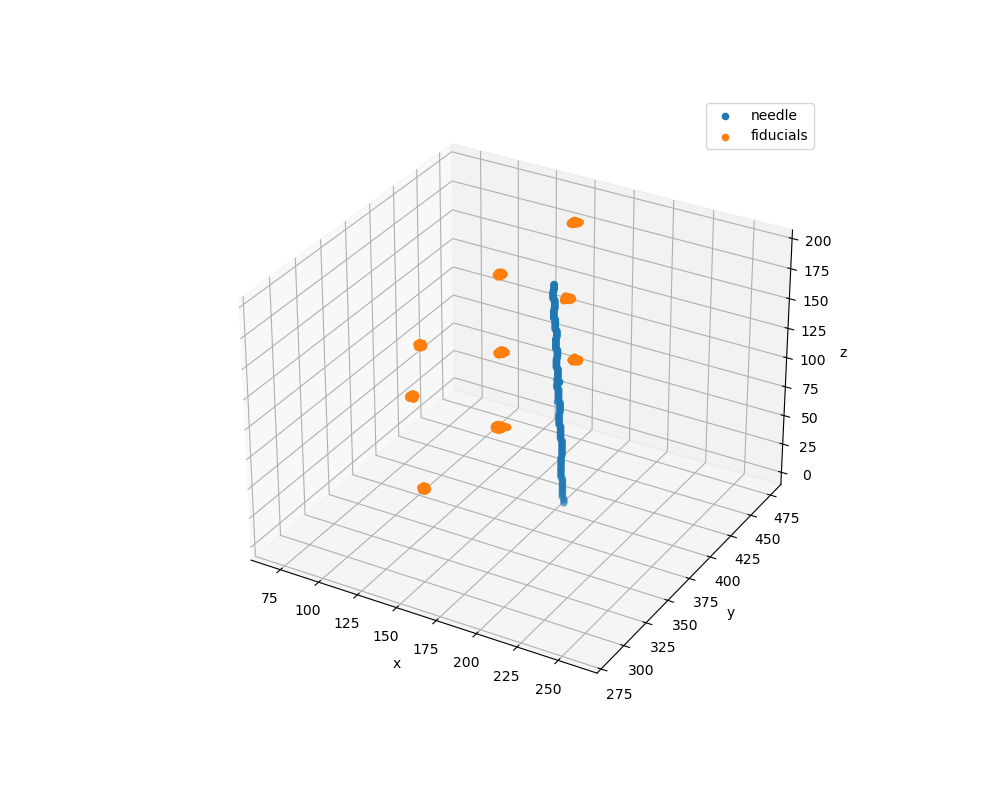

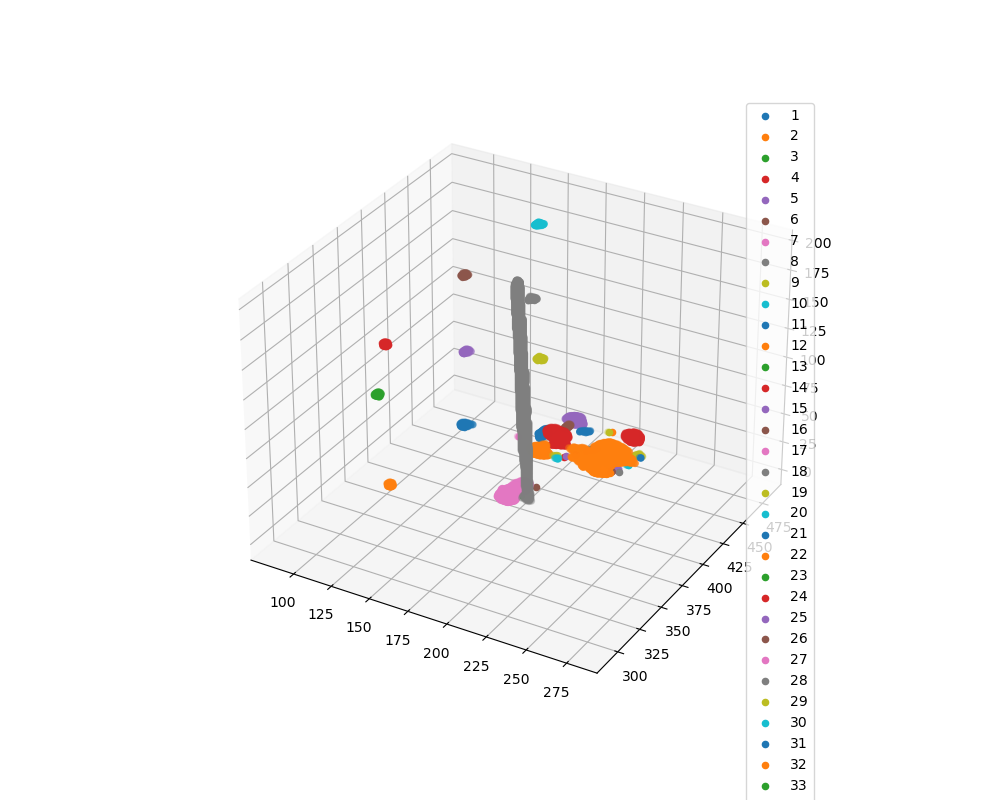

dict_keys(['needle_mask', 'label_needle_mask', 'fiducials_mask', 'fiducial_pts_img', 'needle_pts'])

In [7]:
# ct_nr.options.roi_needle.top_left[0] = 10
plt.close("all")
ret = reconstruct_needle(ct_nr)
ret.keys()

In [8]:
lbl_needle_mask = ret['label_needle_mask']
print({
    lbl: np.sum(lbl_needle_mask == lbl) for lbl in range(1, np.unique(lbl_needle_mask).size)
})

print(np.argmax([
    np.sum(lbl_needle_mask == lbl) for lbl in range(1, np.unique(lbl_needle_mask).size)
]) + 1)

{1: 59, 2: 34, 3: 34, 4: 34, 5: 38, 6: 30, 7: 2, 8: 34, 9: 37, 10: 32, 11: 108, 12: 317, 13: 3, 14: 357, 15: 296, 16: 24, 17: 735, 18: 2285, 19: 5, 20: 5, 21: 14, 22: 2121, 23: 1, 24: 1, 25: 1, 26: 1, 27: 5, 28: 3, 29: 2, 30: 1, 31: 26, 32: 1, 33: 1, 34: 303, 35: 15, 36: 5, 37: 9, 38: 1, 39: 19, 40: 3, 41: 2}
18


In [9]:
lbl_conn = dict()
lbl_conn["None"] = skimage.measure.label(ret['needle_mask'], connectivity=None)
lbl_conn["1"]    = skimage.measure.label(ret['needle_mask'], connectivity=1)
lbl_conn["2"]    = skimage.measure.label(ret['needle_mask'], connectivity=2)

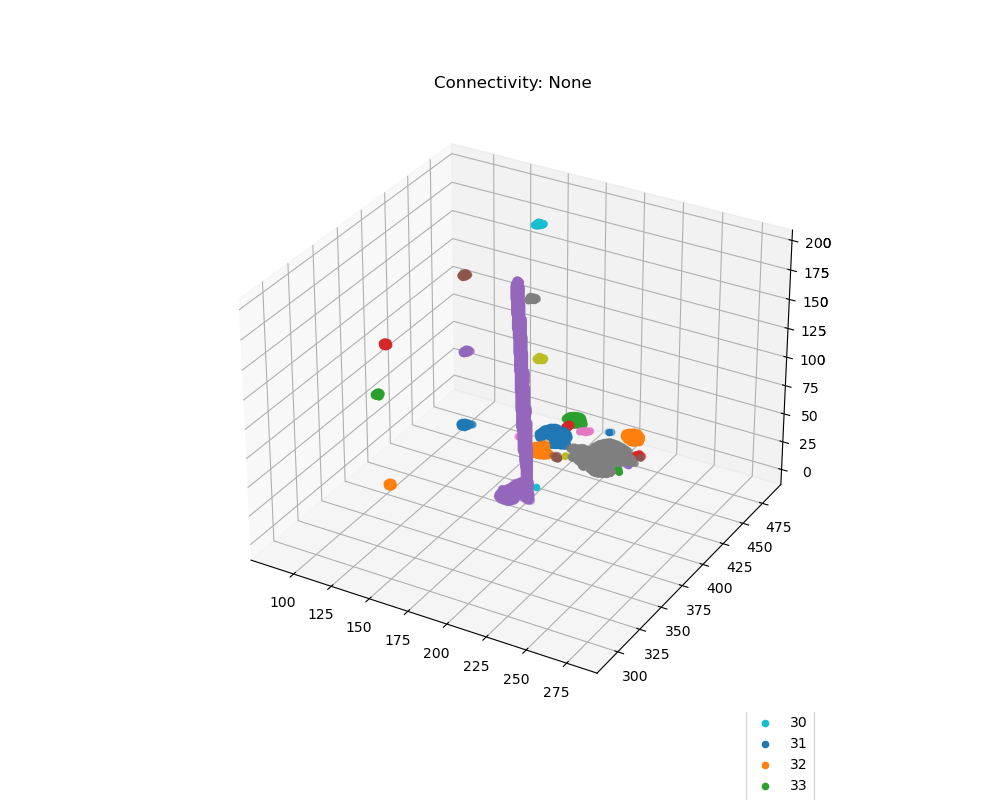

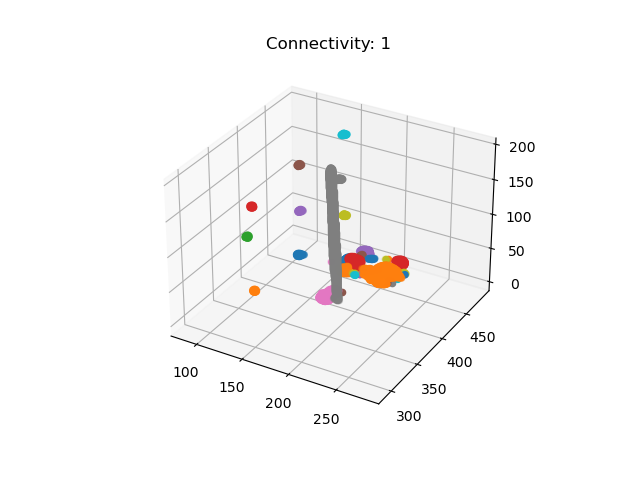

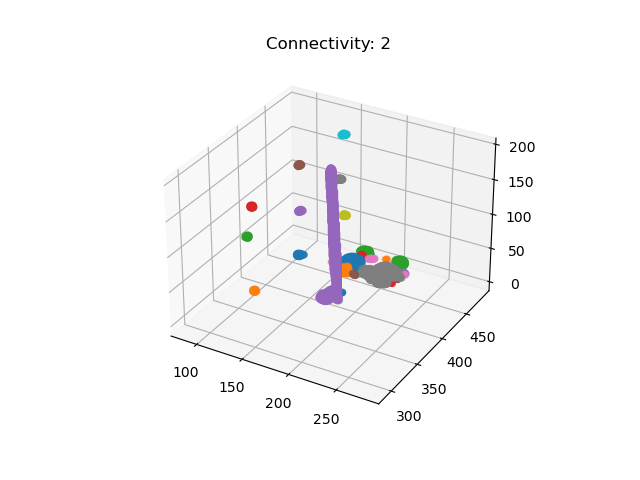

In [10]:
for i, (key, lbl_mask) in enumerate(lbl_conn.items()):
    plt.figure(i+2)

    ax = plt.gcf().add_subplot(111, projection='3d')
    for val in np.unique(lbl_mask):
        if val == 0:
            continue

        pts_val = np.argwhere(lbl_mask == val).astype(np.float64)
        ax.scatter(pts_val[:, 0], pts_val[:, 1], pts_val[:,2])



    # for
    axisEqual3D(ax)
    ax.set_title(f"Connectivity: {key}")

    plt.show()

# for

In [11]:
needle_pts = ret["needle_pts"]
print(needle_pts.shape)

idxs = np.argsort(needle_pts[:, 2])
needle_pts = needle_pts[idxs]

(178, 3)


In [12]:
L, _, s = arclength(needle_pts)
needle_interp_bspl = BSplineND.fit(s, needle_pts, order=3)

ds = 0.5
s_interp = np.arange(0, L, ds)
needle_interp_pts = needle_interp_bspl(s_interp)

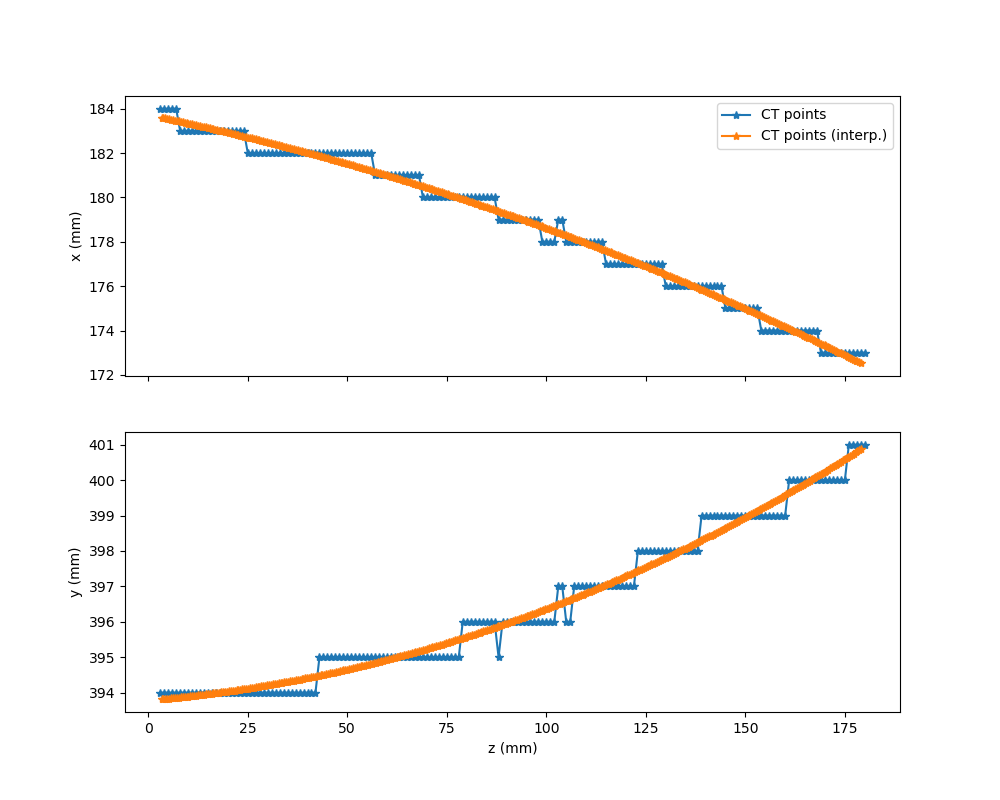

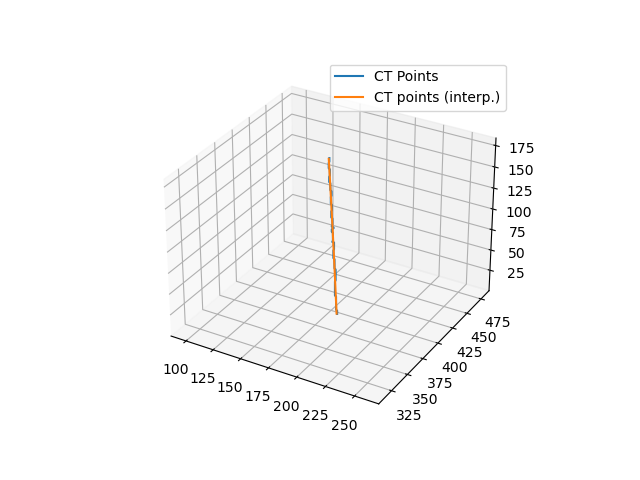

In [20]:
plt.close('all')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(needle_pts[:, 2], needle_pts[:, 0], '-*', label="CT points")
axes[0].plot(needle_interp_pts[:, 2], needle_interp_pts[:, 0], '-*', label="CT points (interp.)")
axes[0].set_ylabel( "x (mm)" )

axes[1].plot(needle_pts[:, 2], needle_pts[:, 1], '-*', label="CT points")
axes[1].plot(needle_interp_pts[:, 2], needle_interp_pts[:, 1], '-*', label="CT points (interp.)")
axes[1].set_ylabel("y (mm)")
axes[1].set_xlabel("z (mm)")

axes[0].legend(loc="best")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(needle_pts[:, 0], needle_pts[:,1], needle_pts[:, 2], label='CT Points')
ax.plot(needle_interp_pts[:, 0], needle_interp_pts[:, 1], needle_interp_pts[:,2], label='CT points (interp.)')

axisEqual3D(ax)

ax.legend(loc='best')

plt.show()

In [14]:
order = 5
polys = [sp.interpolate.BPoly(np.eye(order+1)[i].reshape(-1,1), [0,1]) for i in range(order+1) ]
x = np.arange(4, dtype=float)
x /= x.max()
A = np.stack(list(map(lambda p: p(x), polys)), axis=1)
y = np.arange(3*x.shape[0]).reshape(-1, 3)

c, res, rank, sig = np.linalg.lstsq(A, y, rcond=None)
print(c)
print()
print("A", "x", "y", "c")
print(A.shape, x.shape, y.shape, c.shape)

print()
print(A)

[[ 0.          1.          2.        ]
 [ 1.35692308  2.19692308  3.03692308]
 [ 3.65538462  4.77538462  5.89538462]
 [ 6.42461538  7.54461538  8.66461538]
 [ 6.20307692  7.04307692  7.88307692]
 [ 9.         10.         11.        ]]

A x y c
(4, 6) (4,) (4, 3) (6, 3)

[[1.         0.         0.         0.         0.         0.        ]
 [0.13168724 0.32921811 0.32921811 0.16460905 0.04115226 0.00411523]
 [0.00411523 0.04115226 0.16460905 0.32921811 0.32921811 0.13168724]
 [0.         0.         0.         0.         0.         1.        ]]


In [15]:
sp.interpolate.BPoly([[2]], [0, 1]).__call__(np.arange(4,dtype=float)/4)

array([2., 2., 2., 2.])

In [16]:
L - np.arange(0, L, ds)

array([1.86651997e+02, 1.86151997e+02, 1.85651997e+02, 1.85151997e+02,
       1.84651997e+02, 1.84151997e+02, 1.83651997e+02, 1.83151997e+02,
       1.82651997e+02, 1.82151997e+02, 1.81651997e+02, 1.81151997e+02,
       1.80651997e+02, 1.80151997e+02, 1.79651997e+02, 1.79151997e+02,
       1.78651997e+02, 1.78151997e+02, 1.77651997e+02, 1.77151997e+02,
       1.76651997e+02, 1.76151997e+02, 1.75651997e+02, 1.75151997e+02,
       1.74651997e+02, 1.74151997e+02, 1.73651997e+02, 1.73151997e+02,
       1.72651997e+02, 1.72151997e+02, 1.71651997e+02, 1.71151997e+02,
       1.70651997e+02, 1.70151997e+02, 1.69651997e+02, 1.69151997e+02,
       1.68651997e+02, 1.68151997e+02, 1.67651997e+02, 1.67151997e+02,
       1.66651997e+02, 1.66151997e+02, 1.65651997e+02, 1.65151997e+02,
       1.64651997e+02, 1.64151997e+02, 1.63651997e+02, 1.63151997e+02,
       1.62651997e+02, 1.62151997e+02, 1.61651997e+02, 1.61151997e+02,
       1.60651997e+02, 1.60151997e+02, 1.59651997e+02, 1.59151997e+02,
      

In [17]:
fiducial_base_locs = ret["fiducial_pts"] - ret["fiducial_pts"][0]
print(fiducial_base_locs)

KeyError: 'fiducial_pts'

In [ ]:
A = np.random.randn(20, 3)
tf = np.eye(4)

tf[:3, :3] = sp.spatial.transform.Rotation.from_rotvec(np.random.randn(3)).as_matrix()

idx_perm = np.random.permutation(A.shape[0])
B = A[idx_perm] @ tf[:3, :3].T + tf[:3, -1].T

print(tf)

In [ ]:
Av = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(A))
Bv = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(B))

In [ ]:
result = o3d.pipelines.registration.registration_icp(
    Av, 
    Bv,
    1
)

result.transformation.round(3)